# Obtenção dos dados

No notebook criado case.ipynb instale a biblioteca do IPEA para obtenção da série temporal em uma célula do notebook:

In [1]:
!pip install ipeadatapy

  Obtaining dependency information for ipeadatapy from https://files.pythonhosted.org/packages/f6/2c/8b36052b6e4e884cbdab7bb71c99cde4010a3fb1cbf047524deaf60db656/ipeadatapy-0.1.9-py3-none-any.whl.metadata
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/f9/9b/335f9764261e915ed497fcdeb11df5dfd6f7bf257d4a6a2a686d80da4d54/requests-2.32.3-py3-none-any.whl.metadata
  Obtaining dependency information for charset-normalizer<4,>=2 from https://files.pythonhosted.org/packages/3a/52/9f9d17c3b54dc238de384c4cb5a2ef0e27985b42a0e5cc8e8a31d918d48d/charset_normalizer-3.3.2-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for idna<4,>=2.5 from https://files.pythonhosted.org/packages/76/c6/c88e154df9c4e1a2a66ccf0005a88dfb2650c1dffb6f5ce603dfbd452ce3/idna-3.10-py3-none-any.whl.metadata
  Obtaining dependency information for urllib3<3,>=1.21.1 from https://files.pythonhosted.org/packages/ce/d9/5f4c13cecde62396b0d3fe530a50ccea91e7dfc1

Depois de instalar, importar a biblioteca em uma nova célula do notebook:


In [3]:
import ipeadatapy as ip

Para buscar as séries temporais disponíveis, usar a função list_series:



In [4]:
series = ip.list_series()
print(series)

                     CODE                                               NAME
0            ABATE_ABPEAV                   Abate - aves - peso das carcaças
1            ABATE_ABPEBV                Abate - bovinos - peso das carcaças
2            ABATE_ABPESU                 Abate - suínos - peso das carcaças
3            ABATE_ABQUAV                          Abate - aves - quantidade
4            ABATE_ABQUBV                       Abate - bovinos - quantidade
...                   ...                                                ...
4624  PNADCT_TXPARTCUF_SI  Taxa de participação - sem instrução ou equiva...
4625           PNAD_IAGRV         Domicílios com insegurança alimentar grave
4626           PNAD_IALEV          Domicílios com insegurança alimentar leve
4627           PNAD_IAMOD      Domicílios com insegurança alimentar moderada
4628           PNAD_SATOT                 Domicílios com segurança alimentar

[4629 rows x 2 columns]


Para obter dados de uma série específica, é necessário saber o código da série. É possível encontrar o código no site do IPEA ou na lista de séries.

Nesse case vamos usar o preço por barril do petróleo bruto Brent (FOB), o qual tem o código _EIA366_PBRENT366._

Com o código em mãos, é só usar a função _timeseries_ para obter os dados.

In [5]:
cod = "EIA366_PBRENT366"
eia366 = ip.timeseries(cod)
print(eia366.head(5))


                        CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                        
1986-01-04  EIA366_PBRENT366  1986-01-04T00:00:00-02:00    4      1  1986   
1986-01-05  EIA366_PBRENT366  1986-01-05T00:00:00-02:00    5      1  1986   
1986-01-06  EIA366_PBRENT366  1986-01-06T00:00:00-02:00    6      1  1986   
1986-01-07  EIA366_PBRENT366  1986-01-07T00:00:00-02:00    7      1  1986   
1986-01-08  EIA366_PBRENT366  1986-01-08T00:00:00-02:00    8      1  1986   

            VALUE (US$)  
DATE                     
1986-01-04          NaN  
1986-01-05          NaN  
1986-01-06          NaN  
1986-01-07          NaN  
1986-01-08          NaN  


Para visualizar a série temporal obtida:



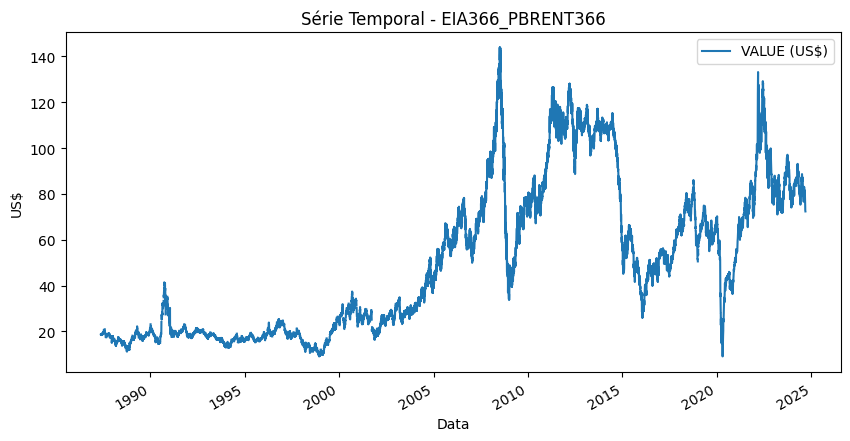

In [6]:
import matplotlib.pyplot as plt

# plota os dados
eia366[["VALUE (US$)"]].plot(figsize=(10, 5))
plt.title("Série Temporal - EIA366_PBRENT366")
plt.xlabel("Data")
plt.ylabel("US$")
plt.show()

# Obtendo novas variáveis com Engenharia de Features

Primeiro vamos checar a tipagem do campo de valor e o index de data, é esperado que o campo de valor seja do tipo _float_ e o index do tipo _data_:

In [7]:
eia366[["VALUE (US$)"]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13522 entries, 1986-01-04 to 2024-09-09
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   VALUE (US$)  11252 non-null  float64
dtypes: float64(1)
memory usage: 211.3 KB


Vamos selecionar somente a variável de interesse, renomear o campo e o index para padronizar:

In [8]:
eia366 = eia366[["VALUE (US$)"]]
eia366.rename(columns={"VALUE (US$)": "value_usd"}, inplace=True)
eia366.index.name = "date"
eia366 = eia366.dropna()
print(eia366)

            value_usd
date                 
1987-05-20      18.63
1987-05-21      18.45
1987-05-22      18.55
1987-05-25      18.60
1987-05-26      18.63
...               ...
2024-09-03      76.46
2024-09-04      74.67
2024-09-05      74.47
2024-09-06      72.82
2024-09-09      72.37

[11252 rows x 1 columns]


Cópia dos dados originais.

In [9]:
df = eia366.copy()

A seguir são criadas variáveis de lag de 1 a 7, para relacionar a variável dependente com os últimos 7 dias de preço do barril do petróleo.

In [10]:
# lags de 1 a 7 dias do preço
for lag in range(1, 8):
    df[f"lag_{lag}"] = df["value_usd"].shift(lag)